In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from models import MLP
from data import gen_rnd_ds
from losses import LinearClassification
from block_analysis import block_hessian, curvature_effects

## Helpers

In [13]:
def get_model_ds_loss():    
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
    ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                   out_dim, nsamp, device)
    loss_fn = LinearClassification(out_dim)
    return model, ds, loss_fn

In [20]:
def pp(lr, delta, h, H):
    rel = abs((h.item() - H.sum().item()) / min(abs(H.sum().item()), abs(h.item())))
    ratio = h.item() / H.sum().item()
    print(f"LR {lr:.2E} \t || Delta={delta:.2E}\t ||Error={rel:.2E}  \t|| hoe={h.item()} \t|| H={H.sum().item()}\t||ratio={ratio}")

def lr_range(model, ds, loss_fn, start=-8, stop=8, step=1, log_scale=False):
    for lr in range(start, stop, step):
        if log_scale:
            lr = 10**lr
        H = block_hessian(model, ds, loss_fn, lr)
        delta, h = curvature_effects(model, ds, loss_fn, lr)
        pp(lr, delta, h, H)

## Params

In [15]:
# Model
mode = "linear"
bias = False
nlayer = 3
inp_dim = 10 
out_dim = 10
hid_dim = 100

# Data parameters
nsamp = 100
inp_mean = 0
inp_var = 1

# Others
device = 0
lr = 7

In [51]:
import torch
from utils import pair_indexes, init_hessian, \
                  clone_model, get_param, \
                  get_delta_params, dot_product

def update_params(params, deltas, lr):
    """
    """
    for param, delta in zip(params, deltas):
        param.data.add_(-lr, delta)
    
def higher_orders(loss_t, loss_t1, lr, grad, delta):
    """
    """
    first_order = dot_product(grad, delta)
    return (loss_t - loss_t1 - lr*first_order) / (2*lr**2)

def eval_loss(model, ds, loss_fn, compute_grad=True):
    """
    """
    loss = 0
    for x,y in ds:
        if compute_grad:
            loss_ = loss_fn(model(x),y)
            loss_.backward()
        else:
            with torch.no_grad():
                loss_ = loss_fn(model(x),y)
        loss+=loss_.item()
    return loss

def block_hessian_off_diag(model, ds, loss_fn, lr):
    """
    """
    base_model = clone_model(model)
    H = init_hessian(base_model)
    # Get loss(t) and gradients
    loss_t = eval_loss(base_model, ds, loss_fn, True)
    grads = {i:x.grad for i,x in enumerate(base_model.parameters())}
    
    for i,j in pair_indexes(base_model):
        # Copy the full model for now.
        # If this is too slow, we should make update_params
        # a context manager instead.
        model = clone_model(base_model)
        pair  = (get_param(model, i), get_param(model, j))
        grad  = (grads[i].clone(), grads[j].clone())
        # Compute delta_theta (=normalized gradient vector for now)
        # But we need to consider other training algo (momentum, etc.)
        delta = get_delta_params(model, grad) 
        # Possible context manager
        update_params(pair, delta, lr) 
        loss_t1 = eval_loss(model, ds, loss_fn, False)
        
        h = higher_orders(loss_t, loss_t1, lr, grad, delta)
        H[i,j] = H[j,i] = h/2
    return H

def block_hessian_diag(model, ds, loss_fn, lr):
    """
    """
    base_model = clone_model(model) 
    diagonal = []
    
    # Get loss(t) and gradients
    loss_t = eval_loss(base_model, ds, loss_fn, True)
    grads = {i:x.grad for i,x in enumerate(base_model.parameters())}

    for i,_ in enumerate(base_model.parameters()):
        model = clone_model(base_model)        
        pair  = (get_param(model, i), )
        grad  = (grads[i].clone(),)
        delta = get_delta_params(model, grad)
        
        update_params(pair, delta, lr)
        loss_t1 = eval_loss(model, ds, loss_fn, False)
        h = higher_orders(loss_t, loss_t1, lr, grad, delta)
        diagonal.append(h)
        
    return torch.cat(list(map(lambda x:x.view((1,)), diagonal)))

def _merge_blocks(H, d):
    """
        Substract H_{ij} = H_{ij}-d_{i}-d_{j}
        Set H_{ii} = d_{i}
    """
    D = -(d.view(1,-1) + d.view(-1,1)) 
    D[range(D.shape[0]), range(D.shape[0])]=d
    return H + D

def block_hessian(model, ds, loss_fn, lr):
    """
        Missing merge_DH(D, H)
    """
    d = block_hessian_diag(model, ds, loss_fn, lr)
    H = block_hessian_off_diag(model, ds, loss_fn, lr)
    return _merge_blocks(H, d)

def curvature_effects(model, ds, loss_fn, lr):
    """
    """    
    model = clone_model(model) 
    # Get loss(t) and gradients
    loss_t = eval_loss(model, ds, loss_fn, True)
    grads = [x.grad for x in model.parameters()]
    delta = get_delta_params(model, grads)
    params = list(model.parameters())
    
    update_params(params, delta, lr)
    loss_t1 = eval_loss(model, ds, loss_fn, False)
    return loss_t - loss_t1, higher_orders(loss_t, loss_t1, lr, grads, delta)

In [44]:
#H = block_hessian(model, ds, loss_fn, lr)
#h = curvature_effects(model, ds, loss_fn, lr)

In [16]:
import torch
from utils import pair_indexes, init_hessian, \
                  clone_model, get_param, \
                  get_delta_params, dot_product

def update_params(params, deltas, lr):
    """
    """
    for param, delta in zip(params, deltas):
        param.data.add_(-lr, delta)
    
def eval_loss(model, ds, loss_fn, compute_grad=True):
    """
    """
    loss = 0
    for x,y in ds:
        if compute_grad:
            loss_ = loss_fn(model(x),y)
            loss_.backward()
        else:
            with torch.no_grad():
                loss_ = loss_fn(model(x),y)
        loss+=loss_.item()
    return loss

In [17]:
def higher_orders(loss_t, loss_t1, lr, grad, delta):
    """
    """
    first_order = dot_product(grad, delta)
    return (loss_t - loss_t1 - lr*first_order) / (lr**2)

In [18]:
def block_hessian_off_diag(model, ds, loss_fn, lr):
    """
        
    """
    base_model = clone_model(model)
    H = init_hessian(base_model)
    # Get loss(t) and gradients
    loss_t = eval_loss(base_model, ds, loss_fn, True)
    grads = {i:x.grad for i,x in enumerate(base_model.parameters())}
    
    for i,j in pair_indexes(base_model):
        # Copy the full model for now.
        # If this is too slow, we should make update_params
        # a context manager instead.
        model = clone_model(base_model)
        pair  = (get_param(model, i), get_param(model, j))
        grad  = (grads[i].clone(), grads[j].clone())
        # Compute delta_theta (=normalized gradient vector for now)
        # But we need to consider other training algo (momentum, etc.)
        delta = grad#get_delta_params(model, grad) 
        # Possible context manager
        update_params(pair, delta, lr) 
        loss_t1 = eval_loss(model, ds, loss_fn, False)
        
        h = higher_orders(loss_t, loss_t1, lr, grad, delta)
        H[i,j] = H[j,i] = h
    return H

def block_hessian_diag(model, ds, loss_fn, lr):
    """
        
    """
    base_model = clone_model(model) 
    diagonal = []
    
    # Get loss(t) and gradients
    loss_t = eval_loss(base_model, ds, loss_fn, True)
    grads = {i:x.grad for i,x in enumerate(base_model.parameters())}

    for i,_ in enumerate(base_model.parameters()):
        model = clone_model(base_model)        
        pair  = (get_param(model, i), )
        grad  = (grads[i].clone(),)
        delta = grad#get_delta_params(model, grad)
        
        update_params(pair, delta, lr)
        loss_t1 = eval_loss(model, ds, loss_fn, False)
        h = higher_orders(loss_t, loss_t1, lr, grad, delta)
        diagonal.append(h)
        
    return torch.cat(list(map(lambda x:x.view((1,)), diagonal)))

def _merge_blocks(H, d):
    """
        Substract H_{ij} = (H_{ij}-d_{i}-d_{j})/2
        Set H_{ii} = d_{i}
    """
    D = -(d.view(1,-1) + d.view(-1,1))
    H = (H+D)/2
    H[range(H.shape[0]), range(H.shape[0])]=d
    return H 

def block_hessian(model, ds, loss_fn, lr):
    """
        Missing merge_DH(D, H)
    """
    d = block_hessian_diag(model, ds, loss_fn, lr)
    H = block_hessian_off_diag(model, ds, loss_fn, lr)
    return _merge_blocks(H, d)

def curvature_effects(model, ds, loss_fn, lr):
    """
        Returns O(lr) terms of the Taylor expansion:
        hoe = L(theta_t1) - L(theta_t) + lr * (delta_theta * grad_theta)
    """    
    model = clone_model(model) 
    # Get loss(t) and gradients
    loss_t = eval_loss(model, ds, loss_fn, True)
    grads = [x.grad for x in model.parameters()]
    delta = grads#get_delta_params(model, grads)
    params = list(model.parameters())
    
    update_params(params, delta, lr)
    loss_t1 = eval_loss(model, ds, loss_fn, False)
    return loss_t - loss_t1, higher_orders(loss_t, loss_t1, lr, grads, delta)

In [21]:
model, ds, loss_fn = get_model_ds_loss()
lr_range(model, ds, loss_fn, -8, 8, 1, True)

LR 1.00E-08 	 || Delta=0.00E+00	 ||Error=6.76E-08  	|| hoe=-115494.40625 	|| H=-115494.3984375	||ratio=1.0000000676439733
LR 1.00E-07 	 || Delta=0.00E+00	 ||Error=8.46E-08  	|| hoe=-11549.4404296875 	|| H=-11549.439453125	||ratio=1.0000000845549695
LR 1.00E-06 	 || Delta=5.82E-10	 ||Error=0.00E+00  	|| hoe=-572.867431640625 	|| H=-572.867431640625	||ratio=1.0
LR 1.00E-05 	 || Delta=1.13E-08	 ||Error=9.05E-01  	|| hoe=-2.571542978286743 	|| H=-4.899842739105225	||ratio=0.5248215331001298
LR 1.00E-04 	 || Delta=1.16E-07	 ||Error=5.23E-01  	|| hoe=0.03388436138629913 	|| H=0.02224309928715229	||ratio=1.5233651097296
LR 1.00E-03 	 || Delta=1.16E-06	 ||Error=2.71E+00  	|| hoe=0.00012869350030086935 	|| H=-0.00022040330804884434	||ratio=-0.5839000396144196
LR 1.00E-02 	 || Delta=1.15E-05	 ||Error=9.53E-01  	|| hoe=1.2369127944111824e-06 	|| H=2.4158453015843406e-06	||ratio=0.512
LR 1.00E-01 	 || Delta=1.15E-04	 ||Error=1.05E-02  	|| hoe=-2.1122104953974485e-06 	|| H=-2.1344476408557966e-06	|

In [99]:
block_hessian_off_diag(model, ds, loss_fn, lr).sum()/2

tensor(-1.0281e-06, device='cuda:0')

In [108]:
H = block_hessian(model, ds, loss_fn, 0.1)
H, H.sum()

(tensor([[3.0930e-04, 2.4471e-07, 7.8022e-07],
         [2.4471e-07, 3.6775e-03, 3.1083e-06],
         [7.8022e-07, 3.1083e-06, 4.3624e-03]], device='cuda:0'),
 tensor(0.0084, device='cuda:0'))

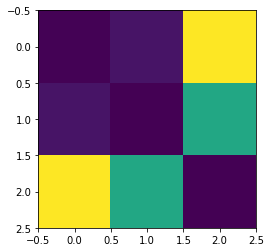

In [110]:
model, ds, loss_fn = get_model_ds_loss()
lr = 1
H = block_hessian(model, ds, loss_fn, lr)
plt.imshow(H.abs().cpu().numpy())

In [104]:
H

tensor([[-8.0036e-11, -5.5043e-09,  1.6940e-07],
        [-5.5043e-09, -2.9104e-10, -4.3772e-08],
        [ 1.6940e-07, -4.3772e-08, -1.7462e-10]], device='cuda:0')

In [8]:
lr_range(model, ds, loss_fn, 1, 20, 1, False)

LR 1.00E+00 	 || Error=6.54E-01  	|| h=0.0019954312592744827 	|| H=0.003301077987998724
LR 2.00E+00 	 || Error=5.72E-01  	|| h=0.0020995535887777805 	|| H=0.003301077987998724
LR 3.00E+00 	 || Error=4.97E-01  	|| h=0.0022055571898818016 	|| H=0.0033010789193212986
LR 4.00E+00 	 || Error=4.27E-01  	|| h=0.0023134429939091206 	|| H=0.0033010775223374367
LR 5.00E+00 	 || Error=3.62E-01  	|| h=0.0024232110008597374 	|| H=0.0033010777551680803
LR 6.00E+00 	 || Error=3.02E-01  	|| h=0.0025348614435642958 	|| H=0.0033010784536600113
LR 7.00E+00 	 || Error=2.46E-01  	|| h=0.0026483931578695774 	|| H=0.003301077289506793
LR 8.00E+00 	 || Error=1.94E-01  	|| h=0.0027638075407594442 	|| H=0.003301076591014862
LR 9.00E+00 	 || Error=1.46E-01  	|| h=0.002881104126572609 	|| H=0.0033010777551680803
LR 1.00E+01 	 || Error=1.00E-01  	|| h=0.0030002829153090715 	|| H=0.0033010775223374367
LR 1.10E+01 	 || Error=5.76E-02  	|| h=0.003121343906968832 	|| H=0.0033010770566761494
LR 1.20E+01 	 || Error=1.75

In [9]:
lr = 11

In [28]:
def func():
    for log_lr in range(-8, 8): 
        lr = 10**log_lr
        H = block_hessian(model, ds, loss_fn, lr)
        h = curvature_effects(model, ds, loss_fn, lr)
        print(lr, h.item(), H.sum().item())
        
func()

1e-08 637691.3125 1571090.625
1e-07 -29363.134765625 -5872.3935546875
1e-06 -258.7601318359375 -121.57786560058594
1e-05 0.8995471000671387 1.8121325969696045
0.0001 0.008458300493657589 0.006585310213267803
0.001 0.00014551915228366852 0.00030877345125190914
0.01 0.00042680767364799976 0.00042782630771398544
0.1 0.00042814062908291817 0.00042815518099814653
1 0.00042816251516342163 0.00042816437780857086
10 0.00042816190398298204 0.00042816210770979524
100 0.00042816175846382976 0.0004281617875676602
1000 0.00042816175846382976 0.00042816175846382976
10000 0.0004281617875676602 0.0004281617875676602
100000 0.00042816181667149067 0.00042816181667149067
1000000 0.0004281617875676602 0.0004281617875676602
10000000 0.00042816175846382976 0.00042816175846382976


In [24]:
for lr in range(10): 
    H = block_hessian(model, ds, loss_fn, lr)
    h = curvature_effects(model, ds, loss_fn, lr)
    print(lr, h.item(), H.sum().item())

0 nan nan
1 0.039547525346279144 0.0537184402346611
2 0.04295935854315758 0.05371849238872528
3 0.04637118801474571 0.05371849983930588
4 0.049783021211624146 0.05371849238872528
5 0.05319485068321228 0.053718503564596176
6 0.05660667642951012 0.053718507289886475
7 0.06001850962638855 0.053718503564596176
8 0.06343034654855728 0.05371851101517677
9 0.06684217602014542 0.05371851474046707


In [19]:
for lr in range(10): 
    H = block_hessian(model, ds, loss_fn, lr)
    h = curvature_effects(model, ds, loss_fn, lr)
    print(lr, h.item(), H.sum().item())

0 nan nan
1 0.0027682632207870483 0.005076628178358078
2 0.00315653532743454 0.0050767287611961365
3 0.003544833976775408 0.005076732020825148
4 0.003933116793632507 0.005076744593679905
5 0.004321407992392778 0.005076759494841099
6 0.004709700588136911 0.005076758563518524
7 0.005097983870655298 0.00507675064727664
8 0.005486276000738144 0.0050767529755830765
9 0.00587456626817584 0.005076766014099121
